## Predicting a Student's Academic Success or Dropout
#### Roselle Deinla & Andrea Nguyen

The aptly named 'Predict student's dropout and academic success' provided to the UCI Machine Learning Repository is a dataset comprised of data collected on graduate, dropout and currently enrolled students of an unnamed post-secondary institution.
The goal of the initial creators of the dataset is to predict trends of a potential dropout student to provide an early intervention to enrolled students who exhibit similar patterns.

The goal of our project is to produce the two most accurate possible models that can predict whether a student will graduate or dropout of their post-secondary institution. Since there is no way of telling what the correct fate of the enrolled students will be, we will also compare our predicted results visually using dimensionality reduction techniques. The structures of our predictions could potentially visually align with the graduate/dropout data. 

Our task at hand is clearly that of binary classification, and our selected models should align as such.

The machine learning models we are interested in training are:
1. K-Nearest Neighbors Classifier (KNN)
2. Logistic Regression
3. Random Forest Classifier
4. Support Vector Machine Classifier (SVC)

K-Nearest Neighbors and the Random Forest algorithm are non-parametric methods. They do not require any strict guidelines for the structure/distribution of the data, but perform best when all features are scaled to the same range.
Random Forest was selected over the binary Decision Tree to reduce the risk of over-fitting and peer into feature importance.

Logisitic Regression and SVC are linear methods, and require more assumptions on the data such as independence between observations and absence of multicollinearity between features. Despite this, linear methods are easy to implement and manipulate. Both methods are already set up for binary classification.

### Loading in the Dataset and Preliminary Preprocessing

In [1]:
#Import all the relevant libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedShuffleSplit, LearningCurveDisplay, learning_curve, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, Isomap, MDS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import r_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import reciprocal, uniform
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
#import seaborn as sns
pd.options.mode.chained_assignment = None 

In [2]:
#load in the dataset
predict_dropout = pd.read_csv('predict_dropout.csv')

In [3]:
#glimpse of the dataset
predict_dropout.head(15)

,Unnamed: 0,Marital.status,Application.mode,Application.order,Course,Daytime.evening.attendance.,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,...,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
0,1,1,17,5,171,1,1,122.0,1,19,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,2,1,15,1,9254,1,1,160.0,1,1,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,3,1,1,5,9070,1,1,122.0,1,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,4,1,17,2,9773,1,1,122.0,1,38,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,5,2,39,1,8014,0,1,100.0,1,37,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,6,2,39,1,9991,0,19,133.1,1,37,...,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,7,1,1,1,9500,1,1,142.0,1,19,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,8,1,18,4,9254,1,1,119.0,1,37,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,9,1,1,3,9238,1,1,137.0,62,1,...,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,10,1,1,1,9238,1,1,138.0,1,1,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


In [4]:
#4424 observations with 37 features! (unnamed: 0 is just a column for the rows...)
predict_dropout.shape

(4424, 38)

In [5]:
predict_dropout.dtypes

Unnamed: 0                                          int64
Marital.status                                      int64
Application.mode                                    int64
Application.order                                   int64
Course                                              int64
Daytime.evening.attendance.                         int64
Previous.qualification                              int64
Previous.qualification..grade.                    float64
Nacionality                                         int64
Mother.s.qualification                              int64
Father.s.qualification                              int64
Mother.s.occupation                                 int64
Father.s.occupation                                 int64
Admission.grade                                   float64
Displaced                                           int64
Educational.special.needs                           int64
Debtor                                              int64
Tuition.fees.u

Lucky for us there are no missing values or extreme outliers as the creators of the dataset have handled that for us. That does not mean we are in the clear just yet.

The features in the data set are a mix of quantitative, ordinal and nominal data. 

Nominal features such as 'Course', 'Nacionality', 'Mother's Qualification','Father's Occupation' etc. do not make sense to leave as a numeric value. The current numeric value represents a label/type rather than a specific ranking/order

Hence, these variables will need to be One-Hot Encoded in order for us start training models

In [6]:
#drop unnamed 0 (may or may not appear in your file)
predict_dropout.drop('Unnamed: 0', axis=1, inplace=True)
#drop father's occupation since there is a large set difference in between enrolled and grad/drop
#please see the markdown block that follows
predict_dropout.drop('Father.s.occupation', axis=1, inplace=True)

In [7]:
#one-hot encode/factor categorical variables that aren't already binary

cat_attribs = ["Marital.status","Application.mode", "Course","Nacionality",
               "Mother.s.qualification", "Father.s.qualification", "Mother.s.occupation"]

full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(sparse_output = False), cat_attribs),
    ])

predict_cat = full_pipeline.fit_transform(predict_dropout)

#rename columns based on original column names, might be useful later
col_names = ["single", "married", "widower", "divorced", "facto union", "legally separated",
              "AM1","AM2","AM5","AM7","AM10", "AM15", "AM16", "AM17", "AM18", "AM26", "AM27", "AM39", "AM42",
              "AM43", "AM44", "AM51", "AM53", "AM57",
              "C33",  "C171", "C8014", "C9003", "C9070", "C9085", "C9119", "C9130", "C9147", "C9238", "C9254",
              "C9500", "C9556", "C9670", "C9773", "C9853", "C9991", 
              "N1", "N2",  "N6",  "N11","N13",  "N14",  "N17",  "N21",  "N22",  "N24",  "N25",  "N26", "N32", "N41",
         "N62", "N100", "N101", "N103", "N105", "N108", "N109",
         "MQ1", "MQ2", "MQ3", "MQ4", "MQ5", "MQ6", "MQ9", "MQ10", "MQ11", "MQ12", "MQ14", "MQ18", "MQ19", "MQ22",
         "MQ26","MQ27", "MQ29", "MQ30", "MQ34", "MQ35", "MQ36", "MQ37", "MQ38", "MQ39", "MQ40", "MQ41", "MQ42", "MQ43", 
         "MQ44", "FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6", "FQ9", "FQ10", "FQ11", "FQ12", "FQ13", "FQ14", "FQ18", "FQ19", "FQ20",
         "FQ22", "FQ25", "FQ26","FQ27", "FQ29", "FQ30", "FQ31", "FQ33", "FQ34", "FQ35", "FQ36", "FQ37", "FQ38", "FQ39", 
         "FQ40", "FQ41", "FQ42", "FQ43", "FQ44",
         "MO0", "MO1", "MO2", "MO3", "MO4", "MO5", "MO6", "MO7", "MO8", "MO9", "MO10", "MO90", "MO99", "MO122","MO123",
         "MO125", "MO131", "MO132", "MO134", "MO141", "MO143", "MO144", "MO151", "MO152", "MO153", "MO171", "MO173", "MO175", "MO191", 
         "MO192", "MO193", "MO194"]

cat_data = pd.DataFrame.from_records(predict_cat)
for i in range(0,cat_data.shape[1]):
    cat_data.rename(columns = {cat_data.columns[i]: col_names[i]}, inplace = True)
    
pred_drop = predict_dropout.drop(cat_attribs, axis=1)
pred_dcat = cat_data.join(pred_drop.reset_index(drop=True))

In [8]:
pred_dcat.shape[1]
#after One-Hot Encoding, the number of features we have has 'increased' by more than 5 times!

186

From running set differences in R (which is why it isn't in the notebook!), there are about 12 values for 'Father's Occupation' not shared between the graduate/dropout students and the enrolled students. 

In the respective data splits, these columns will only contain '0' and not contribute to training or final predictions. On preliminary runs, including the feature decreased accuracy as expected.

Hence, that feature is removed from the dataset right away

'Mother's Occupation', 'Nacionality' and 'Mother's/Father's Qualification' also had values unique only to the graduate students. These differences were low however (about 1-3), and so the features were kept in.

In [9]:
#There is still a little bit more of preprocessing to do...

#filter out "Enrolled" targets from the data frame
enrolled_cat = pred_dcat.loc[pred_dcat['Target'] == 'Enrolled']
enrolled_cat['Target'] = enrolled_cat.Target.factorize()[0]
##drop target from enrolled
enrolled_target = enrolled_cat['Target']
enrolled_cat.drop('Target', axis = 1, inplace=True)

In [10]:
enrolled_cat.shape[0]

794

There are 794 enrolled students to make predictions on...

In [11]:
#drop enrolled students from current data frame:
pred_dcat.drop(pred_dcat.loc[pred_dcat['Target']=='Enrolled'].index, inplace=True)

In [12]:
#factorize Target column for classification:
pred_dcat['Target'] = pred_dcat.Target.factorize()[0]
pred_dtarget = pred_dcat['Target']
#pred_dcat.drop('Target', axis = 1,inplace=True)

In [13]:
pred_dcat.shape[0]

3630

... and 3630 graduate and enrolled students to train the models on

In [14]:
sum(pred_dtarget)/ len(pred_dtarget)

0.6085399449035813

Here, we can see that there is roughly a 61/39 split between the graduate and dropout students. It would be best if our training and testing data reflects that:

In [15]:
#separate data into training and testing splits
split_cat = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_cat.split(pred_dcat, pred_dcat['Target']):
    strat_cat_train = pred_dcat.iloc[train_index]
    strat_cat_test = pred_dcat.iloc[test_index]
    
strat_cat_train_y = strat_cat_train.Target
strat_cat_test_y = strat_cat_test.Target

#assign x and drop target (merging code)
strat_train_x = strat_cat_train.drop('Target', axis=1)
strat_test_x = strat_cat_test.drop('Target', axis=1)

strat_test_x  = np.asarray(strat_test_x)
strat_train_x  = np.asarray(strat_train_x)

#drop target from X:
strat_cat_train.drop('Target', axis = 1, inplace=True)
strat_cat_test.drop('Target', axis = 1, inplace=True)

Now we are ready to start training our models!

### Training and Model Evaluation

#### K-Nearest Neighbours

In [17]:
#see how well the data is classified without any changes
knn_try = KNeighborsClassifier() #with default n =5
knn_try.fit(strat_cat_train.values, strat_cat_train_y)

cross_val_score(knn_try,strat_cat_train.values, strat_cat_train_y, cv = 7, scoring = "accuracy")

array([0.80963855, 0.81927711, 0.81927711, 0.86024096, 0.82168675,
       0.8313253 , 0.83816425])

We get an overall accuracy of ~ 82% which is pretty good! Let's see what the learning curve for this model looks like:

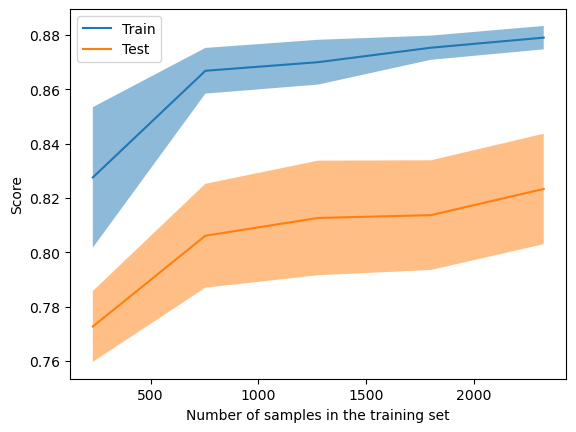

In [26]:
LearningCurveDisplay.from_estimator(knn_try, strat_cat_train.values, strat_cat_train_y)

We can see that there is decent amount of overfitting happening with the gap between the training and testing data...

Let's try to increase the number of neighbors in the model:

In [18]:
knn_try2 = KNeighborsClassifier(n_neighbors = 7)
knn_try2.fit(strat_cat_train.values, strat_cat_train_y)

cross_val_score(knn_try2,strat_cat_train.values, strat_cat_train_y, cv = 7, scoring = "accuracy")

array([0.80481928, 0.82409639, 0.82650602, 0.85060241, 0.84096386,
       0.82650602, 0.82850242])

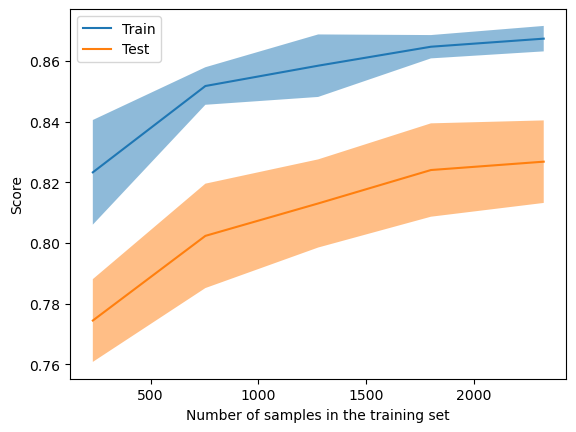

In [28]:
LearningCurveDisplay.from_estimator(knn_try2, strat_cat_train.values, strat_cat_train_y)

The gap between the train and test data is smaller here, reflective of the stabilizing and higher cross-validated accuracies.

Instead of guessing values, let's conduct some hyperparaemeter tuning via grid-search:

In [19]:
#use grid search to tune the hyperparameters and obtain a better model
knn_search = KNeighborsClassifier()

params = {'n_neighbors': [3,5,7,9,11,13,15], 'weights': ['uniform', 'distance'], 
          'algorithm': ['brute', 'kd_tree','ball_tree']}

grid_knn = GridSearchCV(knn_search, params, scoring = "accuracy", cv = 5, return_train_score = True)

In [20]:
grid_knn.fit(strat_cat_train.values, strat_cat_train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['brute', 'kd_tree', 'ball_tree'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [21]:
grid_knn.best_params_

{'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'distance'}

In [22]:
grid_knn.best_score_

0.8340198231349042

The best overall accuracy score over 5 folds is 83.4%

In [24]:
#Let's try this out on test values
knn_best = grid_knn.best_estimator_
knn_best_pred = knn_best.predict(strat_cat_test.values)

knn_mat = confusion_matrix(strat_cat_test_y, knn_best_pred)
print("KNN Confusion Matrix:\n", knn_mat)

KNN Confusion Matrix:
 [[176 108]
 [ 25 417]]


In [26]:
knn_best_acc = accuracy_score(strat_cat_test_y, knn_best_pred)
knn_best_prec = precision_score(strat_cat_test_y, knn_best_pred)
knn_best_rec = recall_score(strat_cat_test_y, knn_best_pred)

print(knn_best_acc,knn_best_prec,knn_best_rec)

0.8168044077134986 0.7942857142857143 0.9434389140271493


Accuracy on the test set is 81.68%, which indicates there is still some slight overfitting happening.

Recall and Precision scores on the test set are imbalanced, favouring recall. This implies the threshold set might be too high. Perhaps we could tune that?

In [27]:
#Use predict_proba to get class probabilities instead
knn_best_pred = knn_best.predict_proba(strat_cat_test.values)
knn_best_pred = knn_best_pred[:,1]

for i in range(0,len(knn_best_pred)):
    check_val = knn_best_pred[i]
    if(check_val > 0.55): #set threshold to be 0.55 instead of 0.5
        knn_best_pred[i] = 1
    else:
        knn_best_pred[i] = 0

In [28]:
knn_best_acc = accuracy_score(strat_cat_test_y, knn_best_pred)
knn_best_prec = precision_score(strat_cat_test_y, knn_best_pred)
knn_best_rec = recall_score(strat_cat_test_y, knn_best_pred)

print(knn_best_acc,knn_best_prec,knn_best_rec)


0.8195592286501377 0.8019417475728156 0.9343891402714932


By changing the threshold, there is a better balance. Although, the overall metrics aren't spectacular

KNN works better on scaled data, perhaps transforming our data will give us better results:

In [29]:
#robust scaler has worked the best compared to Standard and MinMax
#not planning on renaming columns for the knn data since it will not be used later...
scaler_knn = RobustScaler() 
knn_scale_train = scaler_knn.fit_transform(strat_cat_train.values)
knn_scale_test = scaler_knn.fit_transform(strat_cat_test.values)
knn_scale_enroll = scaler_knn.fit_transform(enrolled_cat.values)
knn_scale_train = pd.DataFrame(knn_scale_train)
knn_scale_test = pd.DataFrame(knn_scale_test)
knn_scale_enroll = pd.DataFrame(knn_scale_enroll)

In [30]:
knn_scale_trainy = strat_cat_train_y
knn_scale_testy = strat_cat_test_y

In [31]:
#try out the scaled data with the best model parameters obtained earlier:
knn_scale_try = KNeighborsClassifier(n_neighbors = 9, algorithm = 'brute')
knn_scale_try.fit(knn_scale_train.values, knn_scale_trainy)
cross_val_score(knn_try, knn_scale_train.values, knn_scale_trainy, cv = 7, scoring = 'accuracy')

array([0.80240964, 0.83373494, 0.85301205, 0.86987952, 0.86024096,
       0.8626506 , 0.86231884])

The accuracy scores are definitely better, more noticeably on the later folds!

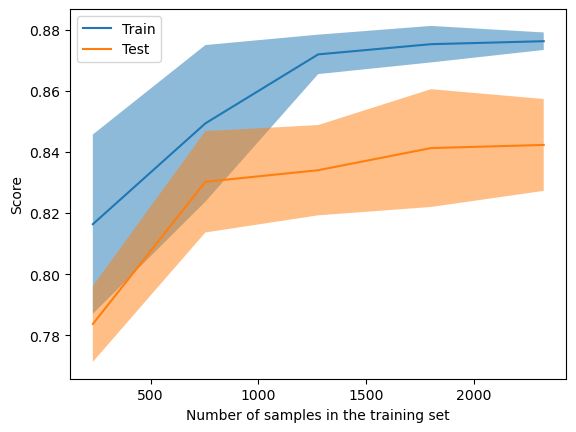

In [40]:
LearningCurveDisplay.from_estimator(knn_scale_try, knn_scale_train.values, knn_scale_trainy)

The band between train and test has definitely improved! A shame that the learning curves do not continue to overlap.

Let's run another grid serach and see what should be the optimal parameters of the model for the scaled data:

In [32]:
knn_search2 = KNeighborsClassifier()

params = {'n_neighbors': [3,5,7,9,11,13,15], 'weights': ['uniform', 'distance'], 
          'algorithm': ['brute', 'kd_tree','ball_tree']}

grid_knn2 = GridSearchCV(knn_search, params, scoring = "accuracy", cv = 5, return_train_score = True)
grid_knn2.fit(knn_scale_train.values, knn_scale_trainy)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['brute', 'kd_tree', 'ball_tree'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [33]:
grid_knn2.best_params_
#almost identical to the unscaled model, but with less neighbors

{'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}

In [34]:
grid_knn2.best_score_
#although the best score is better!

0.8498670544245949

In [35]:
#test the model on the testing data:
knn_scale_best = grid_knn2.best_estimator_
knn_scale_best.fit(knn_scale_train.values, knn_scale_trainy)

knn_scale_best_pred = knn_scale_best.predict(knn_scale_test.values)

In [36]:
knn_scale_mat = confusion_matrix(knn_scale_testy, knn_scale_best_pred)
print("KNN Scaled Confusion Matrix:\n", knn_scale_mat)

KNN Scaled Confusion Matrix:
 [[186  98]
 [ 15 427]]


In [37]:
knn_scale_best_acc = accuracy_score(knn_scale_testy, knn_scale_best_pred)
knn_scale_best_prec = precision_score(knn_scale_testy, knn_best_pred)
knn_scale_best_rec = recall_score(knn_scale_testy, knn_best_pred)

print(knn_scale_best_acc,knn_scale_best_prec,knn_scale_best_rec)

0.8443526170798898 0.8019417475728156 0.9343891402714932


Overall the metrics have improved, but the recall score is still very high....

In [38]:
#knn scale but using predict prob_a instead:
knn_scale_best_pred2 = knn_scale_best.predict_proba(knn_scale_test.values)
knn_scale_best_pred2 = knn_scale_best_pred2[:,1]

for i in range(0,len(knn_scale_best_pred2)):
    check_val = knn_scale_best_pred2[i]
    if(check_val > 0.58):
        knn_scale_best_pred2[i] = 1
    else:
        knn_scale_best_pred2[i] = 0

knn_scale_best_acc2 = accuracy_score(knn_scale_testy, knn_scale_best_pred2)
knn_scale_best_prec2 = precision_score(knn_scale_testy, knn_scale_best_pred2)
knn_scale_best_rec2 = recall_score(knn_scale_testy, knn_scale_best_pred2)

print(knn_scale_best_acc2,knn_scale_best_prec2,knn_scale_best_rec2)

0.8457300275482094 0.8423236514522822 0.918552036199095


Changing the threshold added more of a balance in precision and recall once more, and even increased our accuracy a touch.

Now we should try to predict which students will graduate and dropout from the enrolled students by fitting the enrolled data on our best KNN model:

In [39]:
#Try scaled knn on enrolled students (since it is the better model)
knn_scale_enpred = knn_scale_best.predict_proba(knn_scale_enroll.values)
knn_scale_enpred = knn_scale_enpred[:,1]

for i in range(0,len(knn_scale_enpred)):
    check_val = knn_scale_enpred[i]
    if(check_val > 0.58):
        knn_scale_enpred[i] = 1
    else:
        knn_scale_enpred[i] = 0

knn_grad_perc = sum(knn_scale_enpred/len(knn_scale_enpred))*100
print(knn_grad_perc)

65.61712846347633


KNN predicts that 65.62% of students will graduate. That's 521 future graduate students and 273 future dropouts

In [48]:
########################

#### Logistic Regression

As we know, our dataset now has a bunch of one-hot-encoded features. The most appropriate solver according to the sklearn documentation is 'Newton Cholesky'...

In [50]:
##Naive Logistic Regression - assume all assumptions are met!

logis_try = LogisticRegression(max_iter = 100, solver='newton-cholesky')
logis_try.fit(strat_cat_train.values, strat_cat_train_y)

cross_val_score(logis_try, strat_cat_train.values, strat_cat_train_y, cv = 7, scoring = 'accuracy')
#already there is a much better accuracy score 

array([0.8746988 , 0.91566265, 0.90843373, 0.9253012 , 0.90843373,
       0.9060241 , 0.92028986])

Right away we are hitting a 90% accuracy on 7 folds! Let's see what the learning curves for this model looks like:

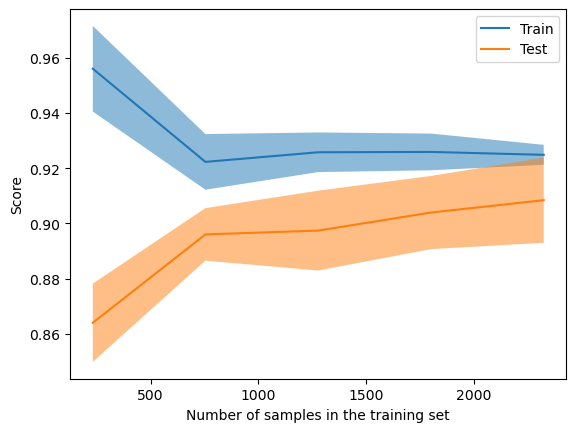

In [51]:
LearningCurveDisplay.from_estimator(logis_try, strat_cat_train.values, strat_cat_train_y)

The gap between the training and testing data almost begins to converge.

It is easy to see that the Logistic Eegression model does not overfit as much as the KNN models, thus explaining the increased accuracy.

We know that features highly correlated with the target will contribute most to the regression model.

Let's see which features are the most correlated to the target in the training data:

In [40]:
target_r_coeff = r_regression(strat_cat_train.values, strat_cat_train_y)
r_coeffs_sorted = sorted(target_r_coeff, reverse = True)
r_coeffs_sorted[0:5]

[0.6519432152538618,
 0.6088851955224561,
 0.5517676110591266,
 0.5236952242547307,
 0.4384957806510356]

Arguably there isn't a lot of "strong" correlation here. However, let's see what exactly are the top 5 most correlated features to the target

In [41]:
#grabbing their column indices and feature names:
top_corr = r_coeffs_sorted[0:5]
top_corr_indices = [0,0,0,0,0]
for i in range(0,5):
       top_corr_indices[i] = np.where(target_r_coeff == top_corr[i])[0][0]
top_corr_indices

[179, 180, 173, 174, 165]

In [42]:
col_names2 = list(pred_dcat)
top_corr_cols = ["","","","",""]
for i in range(0,5):
       top_corr_cols[i] = col_names2[top_corr_indices[i]]
top_corr_cols

['Curricular.units.2nd.sem..approved.',
 'Curricular.units.2nd.sem..grade.',
 'Curricular.units.1st.sem..approved.',
 'Curricular.units.1st.sem..grade.',
 'Tuition.fees.up.to.date']

Now we know which features we would like to keep. 

The next step would be to look into features that are strongly correlated to each other, and any features strongly correlated with the features we want to preserve

In [57]:
corr_mat = strat_cat_train.corr()
corr_mat

,single,married,widower,divorced,facto union,legally separated,AM1,AM2,AM5,AM7,...,Curricular.units.1st.sem..without.evaluations.,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP
single,1.000000,-0.859184,-0.050218,-0.396332,-0.207627,-0.100488,0.238892,-0.021080,0.018167,-0.069237,...,-0.055680,-0.097722,-0.048037,-0.039473,0.059203,0.081360,-0.030259,0.034223,-0.016733,0.059591
married,-0.859184,1.000000,-0.005894,-0.046514,-0.024367,-0.011793,-0.195579,0.026949,-0.015609,0.046409,...,0.040289,0.092123,0.032410,0.024528,-0.046330,-0.058355,0.020894,-0.034989,0.012379,-0.072565
widower,-0.050218,-0.005894,1.000000,-0.002719,-0.001424,-0.000689,0.023390,-0.000597,-0.000912,-0.003612,...,0.107968,-0.005406,-0.010621,0.019829,-0.026482,-0.033799,0.100075,-0.005986,0.002316,0.014332
divorced,-0.396332,-0.046514,-0.002719,1.000000,-0.011240,-0.005440,-0.111299,-0.004710,-0.007200,0.022708,...,0.029972,0.025397,0.029186,0.026012,-0.032589,-0.053157,0.006265,-0.010073,-0.001558,0.002430
facto union,-0.207627,-0.024367,-0.001424,-0.011240,1.000000,-0.002850,-0.060890,-0.002468,-0.003772,0.081343,...,0.005812,0.027030,0.034246,0.022935,0.003431,-0.005368,0.017212,0.000627,0.040983,0.015360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Curricular.units.2nd.sem..grade.,0.081360,-0.058355,-0.033799,-0.053157,-0.005368,-0.025985,0.144463,0.011907,0.012761,-0.072112,...,-0.059249,0.142063,0.405462,0.459670,0.790357,1.000000,-0.058173,-0.000778,-0.044339,0.058070
Curricular.units.2nd.sem..without.evaluations.,-0.030259,0.020894,0.100075,0.006265,0.017212,-0.006902,-0.052783,-0.005976,-0.009135,0.076493,...,0.568358,0.080782,0.056110,0.183558,-0.039347,-0.058173,1.000000,0.027818,-0.032663,-0.075554
Unemployment.rate,0.034223,-0.034989,-0.005986,-0.010073,0.000627,0.012729,-0.062824,-0.002738,-0.023486,0.034604,...,-0.030553,0.015904,0.066799,0.058118,0.044092,-0.000778,0.027818,1.000000,-0.034967,-0.345292
Inflation.rate,-0.016733,0.012379,0.002316,-0.001558,0.040983,-0.029010,0.018360,-0.019293,0.024457,0.020034,...,-0.041925,0.019760,0.027788,0.001100,-0.030555,-0.044339,-0.032663,-0.034967,1.000000,-0.131486


Right away we can see that 'single' and 'married' students have a strong negative correlation.

In [43]:
pred_dcat[pred_dcat['married'] == 1].shape[0]

327

Since there are less than 500 married students in the data, we can safely drop those observations from the train/test and enrolled student data frame without much sacrifice

It is hard to view many correlations at once due to the number of features. Let's take a closer look to the term-related features

In [62]:
corr_mat.loc['Curricular.units.1st.sem..credited.':'Curricular.units.2nd.sem..without.evaluations.','Curricular.units.1st.sem..credited.':'Curricular.units.2nd.sem..without.evaluations.']

,Curricular.units.1st.sem..credited.,Curricular.units.1st.sem..enrolled.,Curricular.units.1st.sem..evaluations.,Curricular.units.1st.sem..approved.,Curricular.units.1st.sem..grade.,Curricular.units.1st.sem..without.evaluations.,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.
Curricular.units.1st.sem..credited.,1.000000,0.781878,0.571705,0.633757,0.132414,0.149442,0.948614,0.646372,0.446264,0.491342,0.145486,0.066296
Curricular.units.1st.sem..enrolled.,0.781878,1.000000,0.699100,0.773073,0.383579,0.143612,0.764712,0.940433,0.620127,0.674198,0.370819,0.067738
Curricular.units.1st.sem..evaluations.,0.571705,0.699100,1.000000,0.559160,0.425091,0.287390,0.552833,0.626888,0.789302,0.463851,0.345986,0.170417
Curricular.units.1st.sem..approved.,0.633757,0.773073,0.559160,1.000000,0.715898,0.023533,0.616067,0.738621,0.583338,0.916460,0.714833,-0.018632
Curricular.units.1st.sem..grade.,0.132414,0.383579,0.425091,0.715898,1.000000,-0.051915,0.121123,0.414187,0.511758,0.695630,0.847524,-0.027101
Curricular.units.1st.sem..without.evaluations.,0.149442,0.143612,0.287390,0.023533,-0.051915,1.000000,0.146977,0.109566,0.173836,0.006854,-0.059249,0.568358
Curricular.units.2nd.sem..credited.,0.948614,0.764712,0.552833,0.616067,0.121123,0.146977,1.000000,0.679909,0.455307,0.520080,0.142063,0.080782
Curricular.units.2nd.sem..enrolled.,0.646372,0.940433,0.626888,0.738621,0.414187,0.109566,0.679909,1.000000,0.624291,0.703905,0.405462,0.056110
Curricular.units.2nd.sem..evaluations.,0.446264,0.620127,0.789302,0.583338,0.511758,0.173836,0.455307,0.624291,1.000000,0.507642,0.459670,0.183558
Curricular.units.2nd.sem..approved.,0.491342,0.674198,0.463851,0.916460,0.695630,0.006854,0.520080,0.703905,0.507642,1.000000,0.790357,-0.039347


There are lots of strongly correlated (r > 0.75) features here.

From trial and error, 'Curricular units 2nd sem grade' and 'Curricular units 2nd sem credited' will be reomved.

'Curricular units 2nd sem grade' is the 2nd most correlated feature with the target, but it is highly correlated with the first. So it can be safely removed.'Curricular units 2nd sem credited' is strongly correlated with 'Curricular units 1st sem approved' and its removal improved model accuracy

Removing other strongly correlated features dropped accuracy, most likely since the term-related features are all
correlated to one another in some form

Now we will drop the married students, and remove two features from the data and see how it will improve the model:

In [44]:
#pred_drop = predict_dropout.drop(cat_attribs, axis=1)
drop_married = cat_data.join(pred_drop.reset_index(drop=True))

#drop married students
index_married = drop_married[drop_married['married'] == 1].index
drop_married.drop(index_married, axis = 0, inplace = True)
#drop curricular units 2nd sem grade and married:
drop_married.drop(['Curricular.units.2nd.sem..grade.', 'married', 'Curricular.units.2nd.sem..credited.'],
               axis = 1, inplace = True)

In [45]:
#filter out "Enrolled" targets from the data frame
enrolled_drop = drop_married.loc[drop_married['Target'] == 'Enrolled']
enrolled_drop['Target'] = enrolled_drop.Target.factorize()[0]
##drop target from enrolled
enrolled_drop_target = enrolled_drop['Target']
enrolled_drop.drop('Target', axis = 1, inplace=True)

In [46]:
#drop enrolled students from current data frame:
drop_married.drop(drop_married.loc[drop_married['Target']=='Enrolled'].index, inplace=True)

In [47]:
#factorize Target column for classification:
drop_married['Target'] = drop_married.Target.factorize()[0]

In [48]:
split_logis = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_logis.split(drop_married, drop_married['Target']):
    logis_drop_train = drop_married.iloc[train_index]
    logis_drop_test = drop_married.iloc[test_index]
    
logis_drop_trainy = logis_drop_train.Target
logis_drop_testy = logis_drop_test.Target

#drop target from X:
logis_drop_train.drop('Target', axis = 1, inplace=True)
logis_drop_test.drop('Target', axis = 1, inplace=True)

In [49]:
#trying out the regression on the "reduced" dataset:

logis_drop_try = LogisticRegression(solver="newton-cholesky")
logis_drop_try.fit(logis_drop_train.values, logis_drop_trainy)

cross_val_score(logis_drop_try, logis_drop_train.values, logis_drop_trainy, cv = 7, scoring = 'accuracy')

array([0.92063492, 0.92063492, 0.92063492, 0.90981432, 0.90981432,
       0.91511936, 0.90450928])

The cross-validated accuracues are more stable in the early 90% 's. Let's look at the learning curves once more:

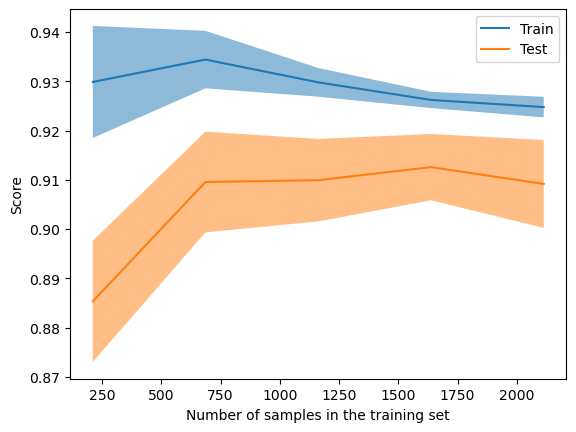

In [71]:
LearningCurveDisplay.from_estimator(logis_drop_try, logis_drop_train.values, logis_drop_trainy)

Overfitting isn't too bad! The gap isn't as extreme in the beginning as it was before, yet it does not appear to begin to overlap with the test set. However, we could eyeball and guess that the area between the training and testing data is roughly the same as compared to the non-dropped feature data.

Maybe some hyperparameter tuning will do the trick:

In [50]:
#trying some hyper-parameter tuning:
logis_tune = LogisticRegression(solver='newton-cholesky') 
#still want to keep the same solver since it sounds most appropriate to our data
logis_params = {'C': [0.3, 0.35, 0.4, 0.425, 0.45, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.35], 'fit_intercept': [True, False],
               'class_weight': [None, 'balanced']}
grid_logis = GridSearchCV(logis_tune, logis_params, scoring = "accuracy", cv = 7, return_train_score = True)

In [51]:
grid_logis.fit(logis_drop_train.values, logis_drop_trainy)

GridSearchCV(cv=7, estimator=LogisticRegression(solver='newton-cholesky'),
             param_grid={'C': [0.3, 0.35, 0.4, 0.425, 0.45, 0.5, 0.7, 0.8, 0.9,
                               1.0, 1.1, 1.2, 1.3, 1.35],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False]},
             return_train_score=True, scoring='accuracy')

In [52]:
grid_logis.best_params_

{'C': 0.45, 'class_weight': None, 'fit_intercept': False}

In [53]:
grid_logis.best_score_

0.917101234835225

91.7 accuracy! Now, that is a good score

In [54]:
#grab best found model and train it once more on the test values:
logis_drop_best = grid_logis.best_estimator_
logis_drop_best.fit(logis_drop_train.values, logis_drop_trainy)

LogisticRegression(C=0.45, fit_intercept=False, solver='newton-cholesky')

In [55]:
#make predictions on the test values:
logis_drop_best_pred = logis_drop_best.predict(logis_drop_test.values)

In [56]:
#view the confusion matrix of the predictions:
logis_drop_mat = confusion_matrix(logis_drop_testy, logis_drop_best_pred)
print("Logistic Confusion Matrix:\n",logis_drop_mat)

Logistic Confusion Matrix:
 [[202  47]
 [ 16 396]]


In [73]:
#see the final accuracy, precision and recall on the test data
logis_drop_acc = accuracy_score(logis_drop_testy, logis_drop_best_pred)
logis_drop_rec = recall_score(logis_drop_testy, logis_drop_best_pred)
logis_drop_prec = precision_score(logis_drop_testy, logis_drop_best_pred)

print(logis_drop_acc, logis_drop_prec, logis_drop_rec)

0.9046898638426626 0.8939051918735892 0.9611650485436893


Again, there are better metrics on the Logistic Regression model compared to the KNN model. As the final accuracy dropped down a bit to 90.46%, there is still some overfititng present.

Interestingly, the recall score for the Logistic Regression model is higher than it's precision score, similar to the KNN model.

Now lets make predictions on the enrolled students:

In [58]:
logis_drop_enrolled_pred = logis_drop_best.predict(enrolled_drop.values)

In [60]:
#percentage of graduates predicted is then...
logis_grad_perc = sum(logis_drop_enrolled_pred)/(enrolled_drop.shape[0])*100
print(logis_grad_perc)

56.73854447439353


From the Logistic Regression, there are 450 future graduate students and 344 future dropouts

In [82]:
#comparison of knn and logistic regression predictions
print("The Logistic Regression model predicts that {0:.2f}% of students will graduate".format(logis_grad_perc))
print("The K-Nearest Neighbors model predicts that {0:.2f}% of students will graduate".format(knn_grad_perc))

The Logistic Regression model predicts that 56.74% of students will graduate
The K-Nearest Neighbors model predicts that 65.62% of students will graduate


It appears that the higher the accuracy, the lower the prediction of graduate students from the enrolled data set.
Considering the dataset has a 60/40 graduate-dropout ratio, perhaps a model with ~97% or greater accuracy will present a prediction ratio closer to 60%

#### Autoencoder Test

One way of performing feature extraction/dimensionality reduction is by creating an AutoEncoder (AE).

The encoder portion of the AutoEncoder will reduce the amount of features to a specified dimension, *n*. The decoder portion will then 'crack' the encoder's information and predict which *n* features from the original data best make up the *n* features.

For time's sake, a simple Sequential AE was constructed to see if it could improve model accuracy:

In [85]:
#Values should be scaled -> switching to MinMax Scaling
#we won't be able to fetch the feature names easily after its been encoded
#so it will be best to save time and not rename them

#set seed for keras
keras.utils.set_random_seed(42)

scaler_ae = MinMaxScaler() 
ae_scale_train = scaler_ae.fit_transform(strat_cat_train.values)
ae_scale_test = scaler_ae.fit_transform(strat_cat_test.values)
ae_scale_enroll = scaler_ae.fit_transform(enrolled_cat.values)
ae_scale_train = pd.DataFrame(ae_scale_train)
ae_scale_test = pd.DataFrame(ae_scale_test)
ae_scale_enroll = pd.DataFrame(ae_scale_enroll)

ae_scale_trainy = strat_cat_train_y
ae_scale_testy = strat_cat_test_y

We will reduce the dataset down to 90 features and see if it will increase accuracy...

In [86]:
input_dim = ae_scale_train.shape[1]

encoding_dim = 90

#grab a validation set to train:
ae_scale_train2, ae_scale_val = train_test_split(ae_scale_train, test_size=0.15, shuffle=True)

#A simple sequential AE
# Set the encoding dimension and build both encoder and decoder
#the final activation layer is 'sigmoid' to return values of '0' or '1'
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
encoder = keras.layers.Dense(160, activation = "relu")(encoder)
encoder = keras.layers.Dense(160, activation = "relu")(encoder)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
#use Binary Crossentropy since we would like to predict two classes
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the autoencoder architecture
#First layer encodes the data into the dimension we want
#The next two layers are hidden
#The output/decoder layer transforms the data back up to the original number of features
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 185)]             0         
                                                                 
 dense (Dense)               (None, 90)                16740     
                                                                 
 dense_1 (Dense)             (None, 160)               14560     
                                                                 
 dense_2 (Dense)             (None, 160)               25760     
                                                                 
 dense_3 (Dense)             (None, 185)               29785     
                                                                 
Total params: 86,845
Trainable params: 86,845
Non-trainable params: 0
_________________________________________________________________


In [92]:
#fit the scaled training data on the autoencoder, using the test set as validation data
autoencoder.fit(ae_scale_train2, ae_scale_train2, epochs=100, batch_size=32, shuffle=True,
                validation_data = (ae_scale_val, ae_scale_val))
#RUN THIS TWICE PLEASE THANKS

Epoch 1/100
78/78 [==============================] - 1s 7ms/step - loss: 0.0409 - val_loss: 0.0516
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0409 - val_loss: 0.0517
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0409 - val_loss: 0.0516
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0408 - val_loss: 0.0517
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0409 - val_loss: 0.0515
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0518
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0520
Epoch 8/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0516
Epoch 9/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0408 - val_loss: 0.0515
Epoch 10/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0408 - val_loss: 0.0516
Epoch 11/

78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0517
Epoch 84/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0516
Epoch 85/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0518
Epoch 86/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0515
Epoch 87/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0407 - val_loss: 0.0519
Epoch 88/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0408 - val_loss: 0.0516
Epoch 89/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0515
Epoch 90/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0407 - val_loss: 0.0515
Epoch 91/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0407 - val_loss: 0.0518
Epoch 92/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0516
Epoch 93/100


In [93]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(ae_scale_train)
encoded_features_test = encoder.predict(ae_scale_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

23/23 [==============================] - 0s 2ms/step
Encoded Features Shape (Train): (2904, 90)
Encoded Features Shape (Test): (726, 90)


In [113]:
#test out on the best Logistic Regression model
logis_ae = LogisticRegression(max_iter = 1000, solver = 'newton-cholesky', C=0.45)
logis_ae.fit(encoded_features_train, ae_scale_trainy)

cross_val_score(logis_ae, encoded_features_train, ae_scale_trainy, cv = 7, scoring = 'accuracy')
#accuracy has not skyrocketed nor improved too much...

array([0.87228916, 0.91084337, 0.91325301, 0.92289157, 0.90361446,
       0.90120482, 0.91062802])

In [114]:
logis_ae_pred = logis_ae.predict(encoded_features_test)
logis_ae_acc = accuracy_score(ae_scale_testy, logis_ae_pred)
logis_ae_acc

0.9090909090909091

Not too bad on the test data! There is an increase in accuracy by ~0.05% if we train the model twice on its weights. 

Encodings to dimensions lower than 90 do not appear to improve model accuracy, and higher dimensions bring the value closer to the value without the AE.

Overall, this margin of increase is too small to really justify using an AE. Perhaps a better architecture could further improve performance, but it is stil hard to say if the resulting output is worth it.

In [115]:
#let's try it out on the enrolled data anyways:
encoded_enroll = encoder.predict(ae_scale_enroll)
logis_ae_pred = logis_ae.predict(encoded_enroll)

25/25 [==============================] - 0s 3ms/step


In [116]:
logis_ae_perc = sum(logis_ae_pred)/(encoded_enroll.shape[0])*100
print(logis_ae_perc)

75.94458438287154


The prediction of graduate students is much higher here, which differs from what we had assumed earlier in the comparison between the non AE Logistic and KNN models

### Random Forest

In [61]:
#Fine-tune the model by Grid Search
param_grid = [
    # try 30 (5×6) combinations of hyperparameters
    {'n_estimators': [10, 20, 30, 35, 40], 'max_features': [4, 6, 8, 10, 12, 14]},
    #try when bootstrap is false
    {'bootstrap': [False], 'n_estimators': [15, 20, 30, 35, 40], 'max_features': [6, 8, 10, 12, 14, 16]},
  ]

forest_reg = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(strat_train_x, strat_cat_train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [4, 6, 8, 10, 12, 14],
                          'n_estimators': [10, 20, 30, 35, 40]},
                         {'bootstrap': [False],
                          'max_features': [6, 8, 10, 12, 14, 16],
                          'n_estimators': [15, 20, 30, 35, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [128]:
#best parameters for the Random Forest model
grid_search.best_params_

{'bootstrap': False, 'max_features': 14, 'n_estimators': 40}

In [66]:
#set the threshold to be 0.5 as standard:
threshold=0.5
y_pred = grid_search.predict(strat_test_x)
y_pred_new = np.where(y_pred > threshold, 1, 0)
rf_best_acc = accuracy_score(strat_cat_test_y, y_pred_new)
print(rf_best_acc)

0.9132231404958677


A test accuracy of 91.32% is great!

In [67]:
rf_best_prec = precision_score(strat_cat_test_y, y_pred_new)
rf_best_rec = recall_score(strat_cat_test_y, y_pred_new)

In [68]:
print(rf_best_prec, rf_best_rec)

0.8956158663883089 0.9705882352941176


Precision and Recall scores are quite high. Once more the recall score is much higher compared to both accuracy and precision

In [69]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(strat_cat_test_y, y_pred_new)

print("Random Forest Confusion Matrix:\n", conf_matrix)

Random Forest Confusion Matrix:
 [[234  50]
 [ 13 429]]


Let's test the model on the enrolled students:

In [71]:
rf_pred_enroll = grid_search.predict(enrolled_cat)
rf_grad_perc = sum(rf_pred_enroll)/(len(rf_pred_enroll))

print(rf_grad_perc)

0.5277078085642317


C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Unsuprisingly we get another graduate prediction percentage in the 50's. The Random Forest model predicts that 419 students will graduate, and 375 students will dropout

##### Feature Importance

By using Feature Importances, we can identify which features have stronger impact on the model's predictions of dropout or graduate

In [77]:
#Determine the important features
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(strat_train_x, strat_cat_train_y)
feature_names = list(pred_dcat.columns)

# Create a list of tuples containing feature names and their scores
features_and_scores = list(zip(feature_names, rnd_clf.feature_importances_))

# Sort the list based on the scores in descending order
sorted_features = sorted(features_and_scores, key=lambda x: x[1], reverse=True)
#grab the top 10 most important features
top_10_features = sorted_features[:10]

In [78]:
# Print the top 10 sorted feature names and scores
for name, score in top_10_features:
       print(name, score)

Curricular.units.2nd.sem..approved. 0.1697388481899313
Curricular.units.1st.sem..approved. 0.12240317375622774
Curricular.units.2nd.sem..grade. 0.10591142048617774
Curricular.units.1st.sem..grade. 0.07731097979752002
Tuition.fees.up.to.date 0.0435199376868597
Curricular.units.2nd.sem..evaluations. 0.03297015972456871
Age.at.enrollment 0.030770748890445135
Admission.grade 0.02826440905975713
Curricular.units.1st.sem..evaluations. 0.02781741112321297
Previous.qualification..grade. 0.025547348881579553


Here, we can see that the top 5 Feature Importances matched the top 5 most correlated values to the target!

In [95]:
# Filter tuples where the importance score is greater than or equal to 0.0013 for later
filtered_features = [name for name, score in features_and_scores if score >= 0.013]
# Convert feature names to corresponding integer indices
filtered_feature_indices = [feature_names.index(name) for name in filtered_features]
filtered_feature_indices
# Use integer indices to select columns from strat_train_x
strat_train_x_filtered = strat_train_x[:, filtered_feature_indices]
strat_test_x_filtered = strat_test_x[:, filtered_feature_indices]

enrolled_x = np.asarray(enrolled_cat)
enrolled_filtered = enrolled_x[:, filtered_feature_indices]

In [96]:
len(filtered_features)

17

The features have been reduced to 17. We will test this dataset later on

In [135]:
#We will predict the enrolled students whether they will drop or graduate
enrolled_cat_new= enrolled_cat.copy()
predicted = grid_search.predict(enrolled_cat_new)
pred_new = np.where(predicted > threshold, 1, 0)
# Replace values in the 'Target' column
enrolled_cat_new['Target'] = pred_new
# Print the DataFrame with the updated 'Target' column
enrolled_cat_new.head(10)

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,single,married,widower,divorced,facto union,legally separated,AM1,AM2,AM5,AM7,...,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6,14,2,11.000000,0,10.8,1.4,1.74,0
19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,7,8,6,13.500000,0,16.2,0.3,-0.92,1
21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,8,9,8,11.425000,0,12.7,3.7,-1.70,1
25,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,6,12,4,11.000000,0,7.6,2.6,0.32,1
27,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,5,7,4,13.000000,0,9.4,-0.8,-3.12,1
29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,7,7,6,13.716667,0,16.2,0.3,-0.92,1
30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6,17,5,10.571429,0,16.2,0.3,-0.92,0
32,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,5,8,2,13.500000,0,8.9,1.4,3.51,0
45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,11,3,14.333333,1,7.6,2.6,0.32,0
51,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,8,10,6,11.833333,0,9.4,-0.8,-3.12,1


In [72]:
#Use the Random Forest model to predict on the enrolled students
rf_pred_enroll = grid_search.predict(enrolled_cat)
rf_grad_perc = sum(rf_pred_enroll)/(enrolled_cat.shape[0])*100
print(rf_grad_perc)

52.77078085642317


C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Now we get a percentage prediction of ~ 52.77% graduate students. This is similar to the best Logistic Regression model

### SVC

The fourth machine learning model we used to predict the students' academic progress (dropout/graduate) is Support
Vector Machine

In [139]:
#The fourth machine model we used is SVM
#Start off by simple SVM Classifier
lin_clf = LinearSVC(random_state=42, dual = 'auto')
lin_clf.fit(strat_train_x, strat_cat_train_y)
#Train on training set
cross_val_score(lin_clf, strat_train_x, strat_cat_train_y, cv = 7, scoring = 'accuracy')

array([0.86746988, 0.90843373, 0.89879518, 0.93012048, 0.91807229,
       0.9060241 , 0.9178744 ])

In [140]:
#evaluate on the test set
y_pred = lin_clf.predict(strat_test_x)
accuracy_score(strat_cat_test_y, y_pred)

0.9132231404958677

In [141]:
#Choose a different C to improve the accuracy
lin_clf2 = LinearSVC(random_state=42,C=0.01, dual = 'auto')
lin_clf2.fit(strat_train_x, strat_cat_train_y)

cross_val_score(lin_clf2, strat_train_x, strat_cat_train_y, cv = 7, scoring = 'accuracy')

y_pred2 = lin_clf2.predict(strat_test_x)
accuracy_score(strat_cat_test_y, y_pred2)
#The accuracy score is slightly better at 91.7%

0.9173553719008265

In [81]:
#We try out scaling the data to get a better accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(strat_train_x.astype(np.float32))
X_test_scaled = scaler.transform(strat_test_x.astype(np.float32))
enrolled_scaled = scaler.transform(enrolled_x.astype(np.float32))

lin_clf_scale = LinearSVC(random_state=42, dual = 'auto')
lin_clf_scale.fit(X_train_scaled, strat_cat_train_y)

cross_val_score(lin_clf_scale, X_train_scaled, strat_cat_train_y, cv = 7, scoring = 'accuracy')

array([0.86746988, 0.90361446, 0.89638554, 0.92771084, 0.91325301,
       0.9060241 , 0.91062802])

In [82]:
#Test on test dataset
y_pred_scaled = lin_clf_scale.predict(X_test_scaled)
accuracy_score(strat_cat_test_y,y_pred_scaled)

0.9118457300275482

Once more we achieve a ~ 91% accuracy score on the test set. Though perhaps due to the seed, the scaled score is lower

In [83]:
#Try out Randomized Search on the linear model
lin_clf3 = SVC(random_state=42,kernel="linear")
param_distr = {"C": uniform(1,7)}

rand_search_lin = RandomizedSearchCV(lin_clf3, param_distr, n_iter=10, scoring="accuracy", cv=5)
rand_search_lin.fit(X_train_scaled, strat_cat_train_y)

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AB6D26E3B0>},
                   scoring='accuracy')

In [84]:
lin_rand_best = rand_search_lin.best_estimator_

In [85]:
#on scaled train data
y_pred_scaled = lin_rand_best.predict(X_train_scaled)
accuracy_score(strat_cat_train_y,y_pred_scaled)

0.9269972451790633

In [86]:
#Test on scaled test dataset
y_pred_scaled = rand_search_lin.predict(X_test_scaled)
accuracy_score(strat_cat_test_y,y_pred_scaled)

0.90633608815427

In [89]:
#Try on new strat_train_x_filtered, we expect to get better accuracy as we only kept some important features
lin_rand_best.fit(strat_train_x_filtered, strat_cat_train_y)
#test data accuracy is then:
y_pred3 = lin_rand_best.predict(strat_test_x_filtered)
lin_best_acc = accuracy_score(strat_cat_test_y, y_pred3)
print(lin_best_acc)

0.9173553719008265


In [88]:
#We try out scaling the filtered data to get a better accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(strat_train_x_filtered.astype(np.float32))
X_test_scaled = scaler.transform(strat_test_x_filtered.astype(np.float32))
enrolled_scale_filtered = scaler.transform(enrolled_filtered.astype(np.float32))

#Test on test dataset
lin_rand_best.fit(X_train_scaled, strat_cat_train_y)
y_pred_scaled2 = lin_rand_best.predict(X_test_scaled)
accuracy_score(strat_cat_test_y,y_pred_scaled2)
#this actually gave the exact same result as before...

0.9173553719008265

In [99]:
#Function created to plot ROC Curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

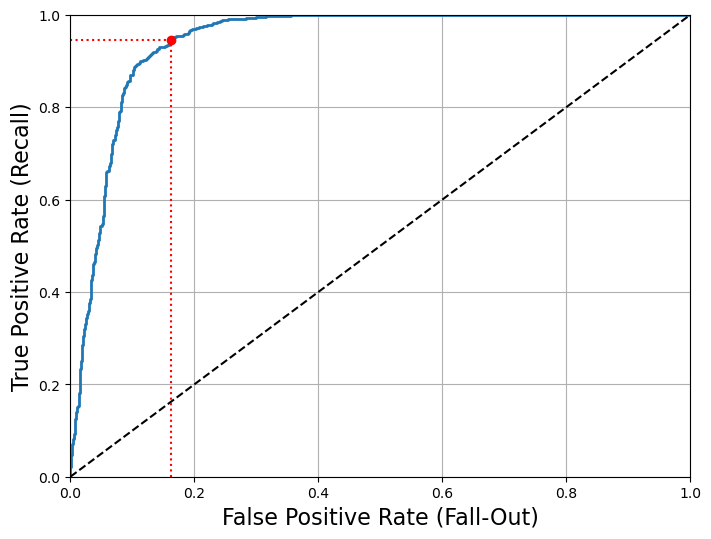

In [100]:
#linear ROC Curve
y_scores_lin = cross_val_predict(lin_rand_best, X_train_scaled, strat_cat_train_y, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(strat_cat_train_y, y_scores_lin)
#Plot ROC Curve
lin_fpr, lin_tpr, lin_thresholds = roc_curve(strat_cat_train_y, y_scores_lin)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(lin_fpr, lin_tpr)
fpr_90 = lin_fpr[np.argmax(lin_tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                                
plt.show()

The ROC curve is very close the upper left corner, which is what we want to see for our models

In [101]:
from sklearn.metrics import roc_auc_score
roc_auc_score(strat_cat_train_y, y_scores_lin)

0.9439424731431665

The AUC score is close to one which is a good sign!

The next SVC model we would like to train is one with an RBF kernel:

In [102]:
#RBF Kernel
svm_clf = SVC(random_state=42,gamma="scale",kernel='rbf')
svm_clf.fit(X_train_scaled, strat_cat_train_y)
#Test on training set
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(strat_cat_train_y, y_pred)

0.9249311294765841

In [103]:
#Test on test set
y_pred = svm_clf.predict(X_test_scaled)
accuracy_score(strat_cat_test_y, y_pred)

0.9090909090909091

In [104]:
#Fine tune the model for RBF Kernel
rbf_clf = SVC(kernel='rbf', random_state = 42)
param_distr = {"C" : uniform(1,10), "gamma" : reciprocal(0.001,0.1)}

rand_search_rbf = RandomizedSearchCV(rbf_clf, param_distr, n_iter=10, scoring="accuracy", cv=3)
rand_search_rbf.fit(X_train_scaled, strat_cat_train_y)
#test on training set
y_pred_rbf = rand_search_rbf.predict(X_train_scaled)
accuracy_score(strat_cat_train_y, y_pred_rbf)

0.9173553719008265

In [105]:
#test on test set
y_pred_rbf = rand_search_rbf.predict(X_test_scaled)
accuracy_score(strat_cat_test_y, y_pred_rbf)

0.9118457300275482

In [ ]:
#For RBF Kernel, after tuning the model , it gave us the accuracy of 91.4%

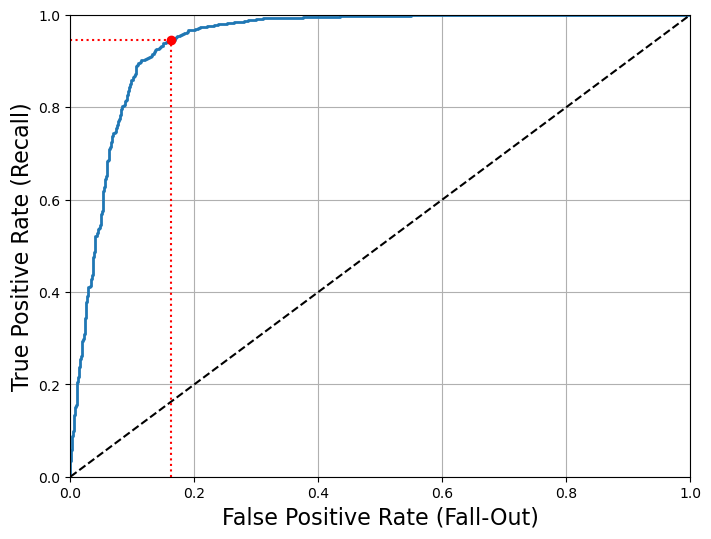

In [106]:
#ROC CURVE RBF
y_scores_rbf = cross_val_predict(rand_search_rbf, X_train_scaled, strat_cat_train_y, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(strat_cat_train_y, y_scores_rbf)
#Plot ROC Curve
rbf_fpr, rbf_tpr, rbf_thresholds = roc_curve(strat_cat_train_y, y_scores_rbf)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(rbf_fpr, rbf_tpr)
fpr_90 = rbf_fpr[np.argmax(rbf_tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                                   
plt.show()

In [107]:
roc_auc_score(strat_cat_train_y, y_scores_rbf)

0.9437717481492762

The AUC score is a bit worse here, but only by ~ 0.002%

Now lets try an SVC with a polynomial kernel:

In [167]:
#Train the polynomial classifier

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42))
    ])
poly_kernel_svm_clf.fit(X_train_scaled, strat_cat_train_y)
# Make predictions on the train set
y_pred_poly = poly_kernel_svm_clf.predict(X_train_scaled)
# Evaluate the model on the test data
accuracy_score(strat_cat_train_y, y_pred_poly)

0.9480027548209367

In [168]:
# Make predictions on the test set
y_pred_poly2 = poly_kernel_svm_clf.predict(X_test_scaled)
# Evaluate the model
accuracy_score(strat_cat_test_y, y_pred_poly2)

0.9049586776859504

The model is over fitting, as it did very well in the training set with accuracy of 94.8% but only 90.49% on test set

In [108]:
#We see that it is overfitting, we should try to reduce the degree
#Choose degree =2
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=2, coef0=1, C=5, random_state=42))
    ])
poly_kernel_svm_clf.fit(X_train_scaled, strat_cat_train_y)
# Make predictions on the test set
y_pred_poly3 = poly_kernel_svm_clf.predict(X_test_scaled)
# Evaluate the model
accuracy_score(strat_cat_test_y, y_pred_poly3)

0.9118457300275482

In [109]:
#Tuning the model
poly_clf = SVC(kernel="poly", random_state=42)
param_distr = {"C": uniform(1,10), "gamma" : reciprocal(0.001,0.1)}

rand_search_poly = RandomizedSearchCV(poly_clf, param_distr, n_iter=10, scoring="accuracy", cv=7)
rand_search_poly.fit(X_train_scaled, strat_cat_train_y)
# Make predictions on the train set
y_pred_poly4 = rand_search_poly.predict(X_train_scaled)
# Evaluate the model on the train set
accuracy_score(strat_cat_train_y, y_pred_poly4)

0.9421487603305785

In [110]:
# Make predictions on the test set
y_pred_poly5 = rand_search_poly.predict(X_test_scaled)
# Evaluate the model
accuracy_score(strat_cat_test_y, y_pred_poly5)

0.9008264462809917

Unfortunately, despite doing well on the train set with accuracy of 94%, the model is still overfitting

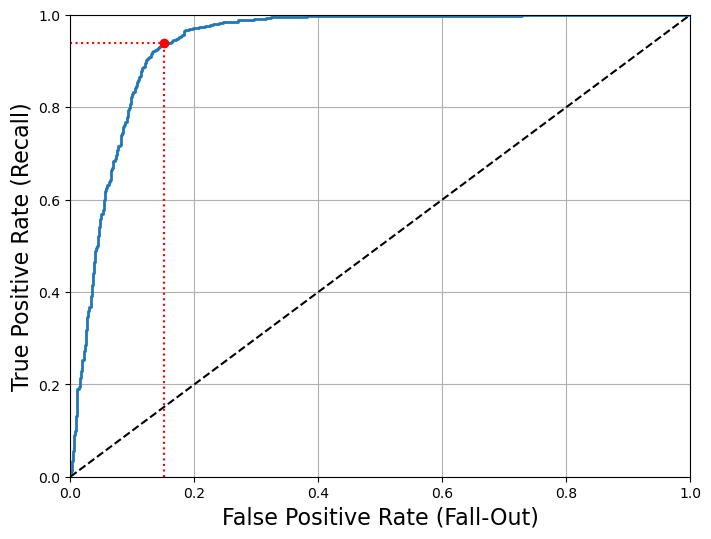

In [111]:
#Poly ROC Curve
y_scores_poly = cross_val_predict(poly_kernel_svm_clf, X_train_scaled, strat_cat_train_y, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(strat_cat_train_y, y_scores_poly)
#Plot ROC Curve
poly_fpr, poly_tpr, poly_thresholds = roc_curve(strat_cat_train_y, y_scores_poly)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(poly_fpr, poly_tpr)
fpr_90 = rbf_fpr[np.argmax(rbf_tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")                                                
plt.show()

In [112]:
roc_auc_score(strat_cat_train_y, y_scores_poly)

0.9393752062512226

Unsurprisingly, the lowest AUC score comes from the Polynomial SVC. This model also overfitted the data the most compared to the other models.

Among the 3 SVM Models, Linear SVM returns the highest accuracy of 91.8%. Let's use that model to predict the enrolled students: 

Based on the 3 ROC Curves on the best model of Linear, RBF Kernel and Polynomial Kernel, they are pretty identical with AUC value close to 1, indicating good classifier with high sensitivity and low false positive rates accross various thresholds. It also justifies our previous conclusion that SVM Linear Kernel is the best SVM Model as its AUC score is the highest.

In [90]:
#first lets get the precision and recall scores:
lin_best_prec = precision_score(strat_cat_test_y, y_pred3)
lin_best_rec = recall_score(strat_cat_test_y, y_pred3)
print(lin_best_prec, lin_best_rec)

0.8946280991735537 0.9796380090497737


Compared to the Random Forest precision and recall metrics, the Linear SVM has roughly a 0.9% increase in both scores.

Now to use the model on the enrolled students:

In [189]:
lin_svm_enroll_pred = lin_rand_best.predict(enrolled_scale_filtered)

lin_svm_grad_perc = sum(lin_svm_enroll_pred)/(lin_svm_enroll_pred.shape[0])*100
print(lin_svm_grad_perc)

59.69773299748111


#### Model Summary

Now that we have trained and tested all of our models, lets take a look at all of their results (without change in threshold):

In [94]:
knn_scores = (knn_scale_best_acc2,knn_scale_best_prec2,knn_scale_best_rec2)
logis_scores = (logis_drop_acc, logis_drop_prec, logis_drop_rec)
rf_scores = (rf_best_acc, rf_best_prec, rf_best_rec)
lin_svc_scores = (lin_best_acc, lin_best_prec, lin_best_rec)

all_scores = {'K Nearest Neighbors': knn_scores, 'Logistic Regression': logis_scores,
             'Random Forest': rf_scores, 'Linear SVC': lin_svc_scores}

compare_scores = pd.DataFrame(all_scores, index = ['Accuracy', 'Precision', 'Recall'])
compare_scores

,K Nearest Neighbors,Logistic Regression,Random Forest,Linear SVC
Accuracy,0.845730,0.904690,0.913223,0.917355
Precision,0.842324,0.893905,0.895616,0.894628
Recall,0.918552,0.961165,0.970588,0.979638


Frome the table, our best two models are then the RandomForestClassifier with a test-set accuracy of 91.33% and Linear SVM with a test-set accuracy of 91.74%. 

KNN performed the worst, with only it's recall score reaching at least 90%.

The Logistic, Random Forest and Linear SVC all have similar metrics.

As stated before, the highest metric among all the models is the recall score, and the lowest metric among all the models is the precision score.

Those two models gave the following graduate percentages:

In [192]:
print("Random Forest Classifier {0:.2f}%".format(rf_grad_perc))
print("Linear SVC that {0:.2f}%".format(lin_svm_grad_perc))

Random Forest Classifier 52.77%
Linear SVC that 59.70%


In [ ]:
#########################################

### Visualizations

First, lets view what the graduate and dropout observations look like.

It was hard to find a perfect dim-reduced visual where the graduates and dropouts are cleanly separated. 

The criterion then came down to: 
1. Are the graduates and dropouts not one convoluted mess?
2. Is there at least a decent cluster of separation in both graduates in dropouts?
3. Is there some sort of unique pattern or structure?

Here are the best 3 dim-reduced visualizations:
(Grey = Dropout, Teal = Graduate)

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


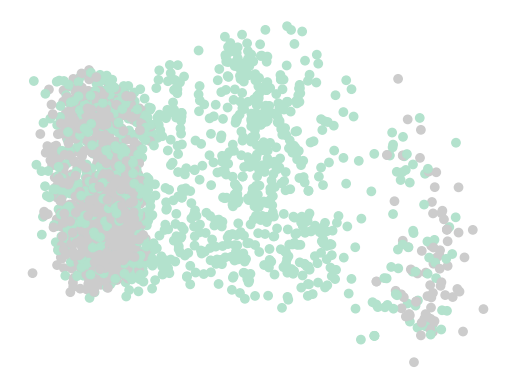

In [98]:
#use same parameters from knn tuning
#Isomap
isomap = Isomap(n_neighbors = 9, neighbors_algorithm = 'brute', metric = 'jaccard')
pred_drop_iso = isomap.fit_transform(pred_dcat)
plt.scatter(pred_drop_iso[:, 0], pred_drop_iso[:, 1], c=pred_dtarget, cmap="Pastel2")
plt.axis('off')
plt.show()

There is a decent chunk of graduate students that occupy the middle of the figure, while most dropout students tend to be gathered on the far left.

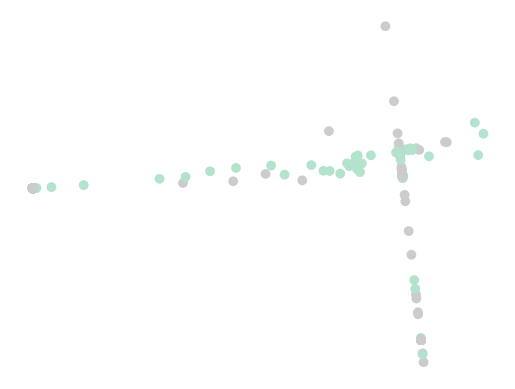

In [99]:
#LLE
lle = LocallyLinearEmbedding(n_components = 2,n_neighbors = 9, neighbors_algorithm = 'brute', random_state = 42)
pred_drop_lle = lle.fit_transform(pred_dcat.drop('Target', axis = 1))
plt.scatter(pred_drop_lle[:, 0], pred_drop_lle[:, 1], c=pred_dtarget, cmap="Pastel2")
plt.axis('off')
plt.show()

LLE gave the most interesting shape out of all the dim-reduced techniques. While the graduate and dropout students are less defined here, comparisons will be easier to articulate due to the output structure.

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


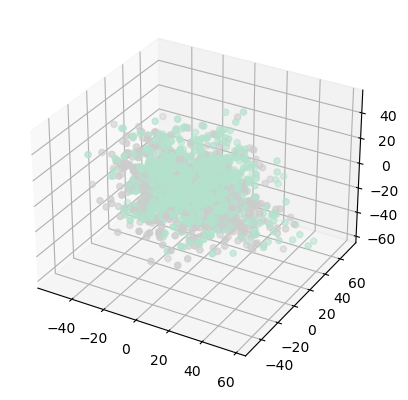

In [101]:
#MDS 3D
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=3, random_state=42)),
])

pred_drop_mds = pca_mds.fit_transform(pred_dcat.drop('Target', axis=1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pred_drop_mds[:, 0], pred_drop_mds[:, 1], pred_drop_mds[:, 2], c=pred_dtarget, cmap="Pastel2")

plt.show()

MDS metric gives is still rather convoluted, but peering into the structure in three-dimensions makes it look as if the graduate students are stacked on top

#### Visualizing on the best models

First, we will visualize the results for the Random Forest classifier:

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


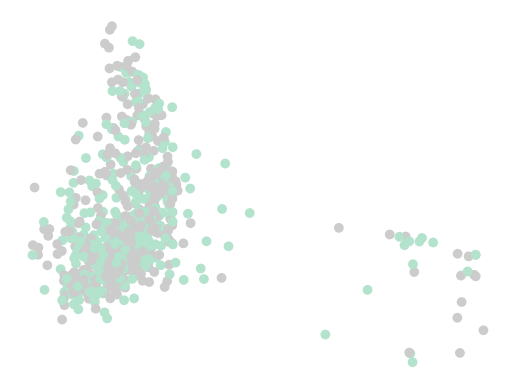

In [198]:
### Random Forest
isomap_rf = Isomap(n_neighbors = 9, neighbors_algorithm = 'brute', metric = 'jaccard')
pred_rf_iso = isomap_rf.fit_transform(enrolled_cat.values)
plt.scatter(pred_rf_iso[:, 0], pred_rf_iso[:, 1], c=rf_pred_enroll, cmap="Pastel2")
plt.axis('off')
plt.show()

Like the isomap of the graduate and dropout students, the isomap for the Random Forest Classifier has a large gathering of data points on the left, and some scattered points on the right.

Unlike the graduate/dropout data, there isn't a large clustering of graduate students in the middle.

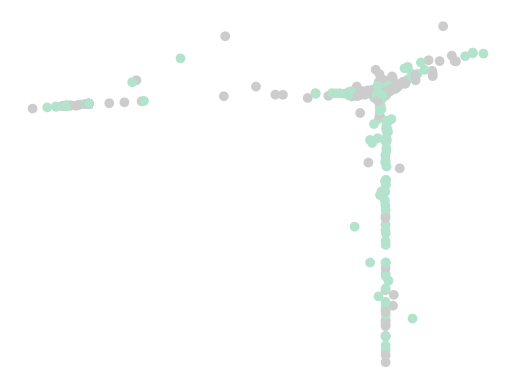

In [197]:
lle_rf = LocallyLinearEmbedding(n_components = 2,n_neighbors = 9, neighbors_algorithm = 'brute', random_state = 42)
pred_rf_lle = lle_rf.fit_transform(enrolled_cat.values)
plt.scatter(pred_rf_lle[:, 0], pred_rf_lle[:, 1], c=rf_pred_enroll, cmap="Pastel2")
plt.axis('off')
plt.show()

The LLE for the Random Forest classifier has a similar shape to the graduate/dropout LLE! We can see more positive values on the 'vertical' line compared to the previous LLE visual, but obtaining this result is very promising.

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


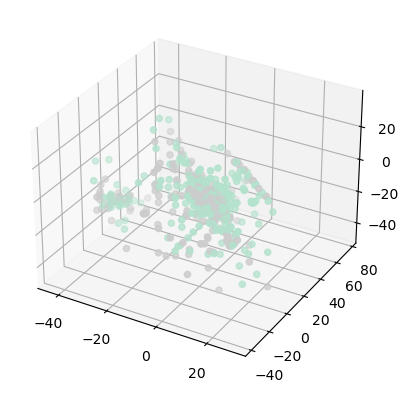

In [196]:
pred_rf_mds = pca_mds.fit_transform(enrolled_cat.values)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pred_rf_mds[:, 0], pred_rf_mds[:, 1], pred_rf_mds[:, 2], c=rf_pred_enroll, cmap="Pastel2")

plt.show()

Considering there aren't as many observations for the enrolled students, the MDS for the Random Forest Classifier isn't as dense. The predicted gradutes look more evenly scattered as well compared to clustering towards the top

Now to visualize the Linear SVC results:

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


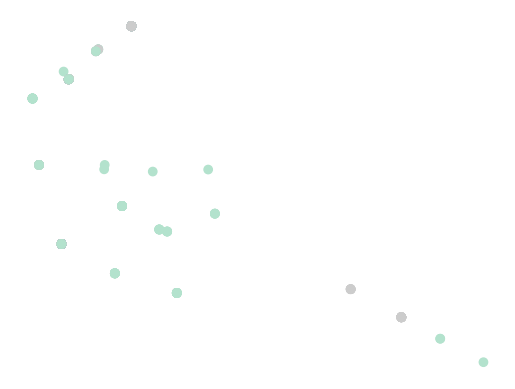

In [205]:
### Linear SVC
#note that the filtered data set was optimal here!

#need n_neighbors = 27 to stop the warnings
isomap_linsvc = Isomap(n_neighbors = 27, neighbors_algorithm = 'brute', metric = 'jaccard')
pred_linsvc_iso = isomap_linsvc.fit_transform(enrolled_filtered)
plt.scatter(pred_linsvc_iso[:, 0], pred_linsvc_iso[:, 1], c=lin_svm_enroll_pred, cmap="Pastel2")
plt.axis('off')
plt.show()

Trying to plot the Isomap results for the Linear SVC model came with a lot of weird warnings. The visual here is much more sparse compared to the other two Isomap's. Granted, there are 17 features in the filtered datasets compared to 185 in the original One-Hot Encoded data

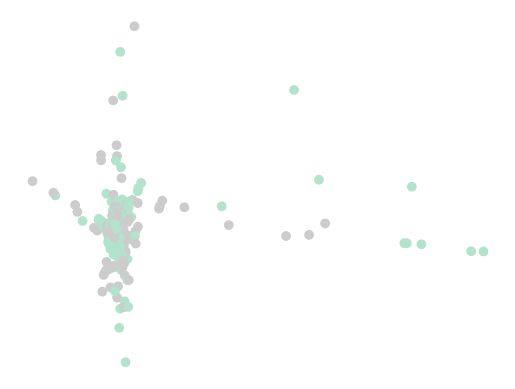

In [208]:
lle_linsvc = LocallyLinearEmbedding(n_components = 2,n_neighbors = 9, neighbors_algorithm = 'brute', random_state = 42)
pred_linsvc_lle = lle_linsvc.fit_transform(enrolled_filtered)
plt.scatter(pred_linsvc_lle[:, 0], pred_linsvc_lle[:, 1], c=lin_svm_enroll_pred, cmap="Pastel2")
plt.axis('off')
plt.show()

The LLE result for the Linear SVC shows a much different pattern again compared to the other LLE visuals. The points deviate from the 'two-intersecting-line' structure we saw earlier. Its even more biased to the left side compared to the right.

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


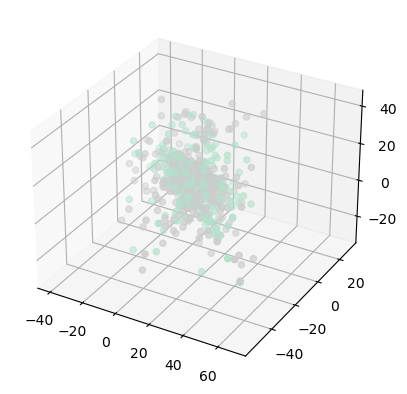

In [209]:
pred_linsvc_mds = pca_mds.fit_transform(enrolled_filtered)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pred_linsvc_mds[:, 0], pred_linsvc_mds[:, 1], pred_linsvc_mds[:, 2], c=lin_svm_enroll_pred, cmap="Pastel2")

plt.show()

Finally, the MDS result for the Linear SVC. The visual here looks more dense compared to the Random Forest MDS model, but is still not as concentrated as the graduate/dropout MDS result. 

Similar to the Random Forest result, the Linear SVC MDS graduate points appear more spread out than concentrated on top.

### Conclusion

Before training our models, we had expected that the non-parametric methods would be more suitable for our data, since it seemed unlikely that a student's academic success is linear. 

However, K-Nearest Neighbors performed the worst compared to the Logistic Regression and Linear SVC models.

Our best model given our initial scoring turned out to be the Linear SVC which gave the 'highest' metrics. Yet, the visual results greatly differed from the graduate/dropout data. The filtered dataset used for the best Linear SVC might have played role in this, however.

Now if we count in the visual results, the Random Forest Classifier is our best model. The metric results only differed by a fraction of a percentage, too.

While no model achieved a mid-high 90% accuracy, the results for the Random Forest Classifier are satisfactory considering the structure of the predictions appear to align similarily with the graduate/dropout data.

There is still much to improve on for many aspects of our trained models. Our balance between precision and recall could improve if we played around more with the threshold value. Overall metrics could possibly improve if we tested out the AE on all models and looked into other scaling methods. Training a neural network might have produced better results given their complexity, but training one is computationally expensive and more time consuming.

We may not have complete confidence in accurately predicting whether an enrolled student will dropout or graduate based on the provided features, but our outcomes don't seem to be too far from the truth. 

###### Reference

Realinho, V., Vieira Martins, M., Tolledo, L., Machado, J., and Baptista, L.M.T. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89. [accessed on October 24, 2023].